In [1]:
import os
import numpy as np
from tqdm.notebook import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [3]:
BASE_DIR = '/Users/dhruvilchodvadiya/Downloads/CV_Project_ImageCaptioning/'
WORKING_DIR = '/Users/dhruvilchodvadiya/Downloads/CV_Project_ImageCaptioning/'

In [4]:
model = VGG16()
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [5]:
# extract features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

In [6]:
for img_name in tqdm(os.listdir(directory)):
    
    # load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    
    # convert image pixels to numpy array
    image = img_to_array(image)
    
    # reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # preprocess image for vgg
    image = preprocess_input(image)
    
    # extract features
    feature = model.predict(image, verbose=0)
    
    # get image ID
    image_id = img_name.split('.')[0]
    
    # store feature
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

2025-05-06 18:46:48.713992: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [7]:
# store features in pickle
import pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [8]:
# load features from pickle
with open(os.path.join(WORKING_DIR, '/Users/dhruvilchodvadiya/Downloads/CV_Project_ImageCaptioning/features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [9]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [10]:
# create mapping of image to captions
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    
    # split the line by comma(,)
    tokens = line.split(',')
    
    if len(line) < 2:
        continue
        
    image_id, caption = tokens[0], tokens[1:]
    
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    
    # convert caption list to string
    caption = " ".join(caption)
    
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
        
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [11]:
len(mapping)


8091

In [12]:
def clean(mapping):
    
    for key, captions in mapping.items():
        
        for i in range(len(captions)):
            
            # take one caption at a time
            caption = captions[i]
            
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            
            # delete digits, special chars, etc., 
            caption = caption.replace('[^A-Za-z]', '')
            
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [13]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [14]:
# preprocess the text
clean(mapping)

In [15]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [16]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
len(all_captions)

40455

In [18]:
all_captions[:5]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8485

In [20]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

In [21]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    
    while 1:
        for key in data_keys:
            
            n += 1
            captions = mapping[key]
            
            # process each caption
            for caption in captions:
                
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
                    
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

In [23]:
# Encoder - Contextual representation

# image feature layers
inputs1 = Input(shape=(4096,))

fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,))

se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder - Generates o/p
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)

# output
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

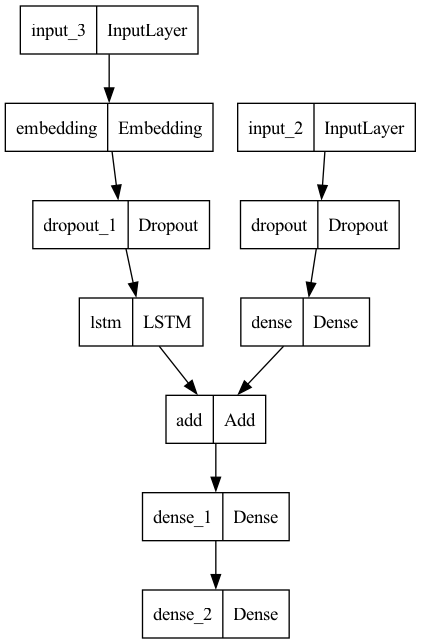

In [24]:
plot_model(model)

In [25]:
# train the model
epochs = 30
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    
    # create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 [==============================] - 125s 549ms/step - loss: 1.9727


In [26]:
model.save(WORKING_DIR+'/best_model.h5')

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    
    # add start tag for generation process
    in_text = 'startseq'
    
    # iterate over the max length of sequence
    for i in range(max_length):
        
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        
        # get index with high probability
        yhat = np.argmax(yhat)
        
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        
        # stop if word not found
        if word is None:
            break
            
        # append word as input for generating next word
        in_text += " " + word
        
        # stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [29]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    
    # get actual caption
    captions = mapping[key]
    
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    
    # append to the list
    actual.append(actual_captions)
    
    predicted.append(y_pred)
    
# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.536041
BLEU-2: 0.305857
BLEU-3: 0.188626
BLEU-4: 0.109305


In [30]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('=============================== Actual ===============================')
    for caption in captions:
        print(caption)
        
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('      ')
    print('============================== Predicted ==============================')
    print(y_pred)
    plt.imshow(image)

=============================== Actual ===============================
startseq backpacker in the mountains using his hiking stick to point at glacier endseq
startseq backpacker points to the snow-capped mountains as he stands on rocky plain endseq
startseq hiker is pointing towards the mountains endseq
startseq hiker poses for picture in front of stunning mountains and clouds endseq
startseq man with green pack using his pole to point to snowcapped mountains endseq
      
============================== Predicted ==============================
startseq man in black hat and sunglasses sits on rocky mountain endseq


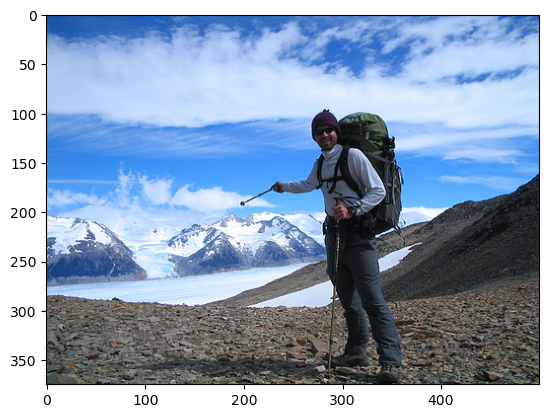

In [31]:
generate_caption("54501196_a9ac9d66f2.jpg")

=============================== Actual ===============================
startseq lone climber on snowcapped mountain with several huge mountains in the background endseq
startseq man is standing looking at the path ahead while hiking in mountain range endseq
startseq man on top of mountain looks at the mountains surrounding him endseq
startseq person with backpack stands on snowy mountain endseq
startseq sole mountain climber stands atop snowy peak looking left endseq


      
============================== Predicted ==============================
startseq man is hiking up mountain as he tries to catch poles endseq


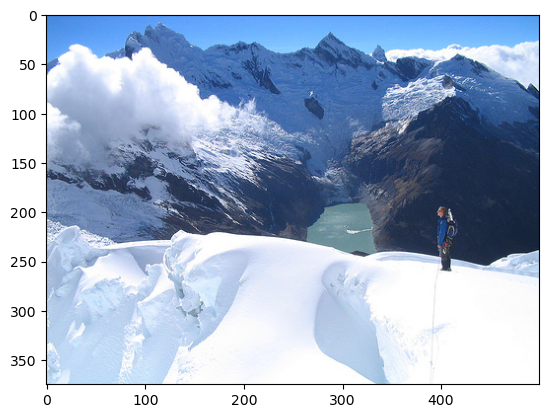

In [32]:
generate_caption("56494233_1824005879.jpg")

=============================== Actual ===============================
startseq brown and white dog is running through the snow endseq
startseq dog is running in the snow endseq
startseq dog running through snow endseq
startseq white and brown dog is running through snow covered field endseq
startseq the white and brown dog is running over the surface of the snow endseq
      
============================== Predicted ==============================
startseq dog running through snow endseq


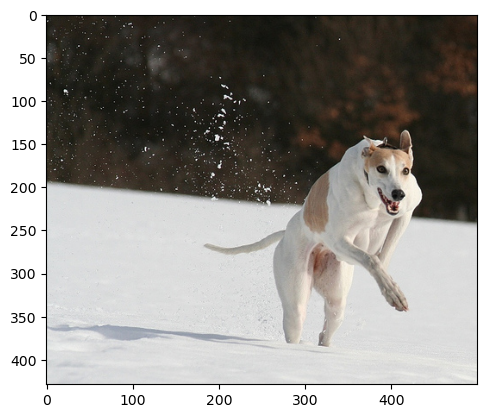

In [33]:
generate_caption("101654506_8eb26cfb60.jpg")

=============================== Actual ===============================
startseq boy wearing no shirt and some blue jeans is jumping in the air in the woods endseq
startseq guy leaps into the air in wooded area endseq
startseq shirtless man jumps in sunny forest endseq
startseq shirtless man jumps over log endseq
startseq the boy is jumping in the woods endseq
      
============================== Predicted ==============================
startseq man jumps in the air while holding stick endseq


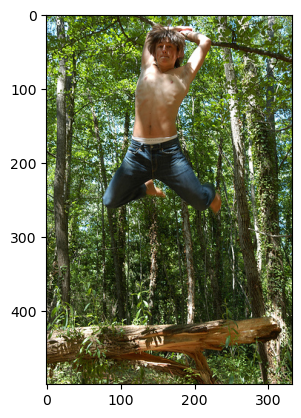

In [34]:
generate_caption("134894450_dadea45d65.jpg")

=============================== Actual ===============================
startseq black and brown furry dog is running in the grass endseq
startseq brown and black dog running through grassy field endseq
startseq large dog frolics in the grass endseq
startseq long haired black and brown dog runs through the grass endseq
startseq black dog running on green grass with mouth open endseq
      
============================== Predicted ==============================
startseq black dog running in the grass endseq


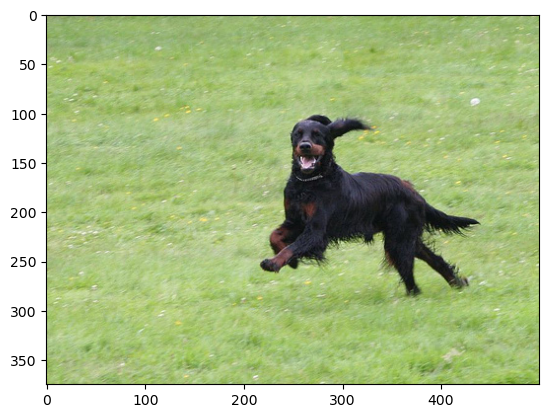

In [35]:
generate_caption("232874193_c691df882d.jpg")

=============================== Actual ===============================
startseq man dressed in grey climbing large brown rock endseq
startseq man in gray shirt climbs large rock wall endseq
startseq man in shorts climbs rock face endseq
startseq man climbing rock wall endseq
startseq the back of man climbing rock endseq
      
============================== Predicted ==============================
startseq man climbing up cliff endseq


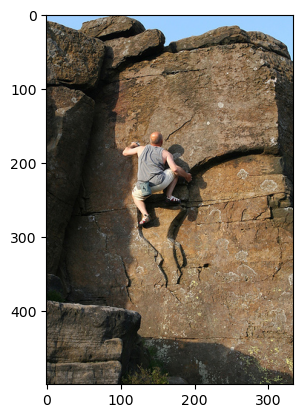

In [36]:
generate_caption("309687244_4bdf3b591f.jpg")